# How to query CODE-DE/EO-Lab Catalogue and download data

The following example shows how to interact with the catalogue and download EO data products for further processing. 
We will search for cloudless Sentinel-2 L1C products over Berlin and create an RGB true color image form one of the products found in the catalogue.

### Import necessary Python modules

In [2]:
# HTTP requests
import requests

# JSON parser
import json

# XML parser
import xml.etree.ElementTree as ET 

# system modules
import os
import re
import sys
import random

# data manipulation
import pandas as pd
import numpy as np

# image manipulation
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image
from rasterio.windows import Window

# file manipulation
from pathlib import Path

# authentication
import getpass
from requests.auth import HTTPBasicAuth

#### Query the catalogue and get a list of products matching the search parameters
Refer to https://knowledgebase.code-de.org/en/latest/eodata/EOData-Catalogue-API-Manual-on-CODE-DE.html#query-structure

In [31]:
# base URL of the product catalogue
catalogue_odata_url = 'https://datahub.code-de.org/odata/v1'

# search parameters
collection_name = 'SENTINEL-2'
product_type = 'S2MSI1C'
max_cloud_cover = 1
aoi = 'POLYGON((13.079076723228969 52.67190595549977,13.684668556820428 52.67139663740849,13.681783407316939 52.3688823284628,13.080391242490544 52.36477941550237,13.079076723228969 52.67190595549977))'
search_period_start = '2023-06-01T00:00:00.000Z'
search_period_end = '2023-06-10T00:00:00.000Z'

#### Build and check the search query

In [32]:
search_query = f"{catalogue_odata_url}/Products?$filter=Collection/Name eq '{collection_name}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}') and ContentDate/Start gt {search_period_start} and ContentDate/Start lt {search_period_end}"

print(f"""\n{search_query.replace(' ', "%20")}\n""")


https://datahub.code-de.org/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI1C')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((13.079076723228969%2052.67190595549977,13.684668556820428%2052.67139663740849,13.681783407316939%2052.3688823284628,13.080391242490544%2052.36477941550237,13.079076723228969%2052.67190595549977))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-06-10T00:00:00.000Z



#### Run the query and display the results

In [33]:
response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response['value'])

# print first 3 results
result.head(3)

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,5e34d920-c5d5-4b21-bded-50790f4bec50,S2B_MSIL1C_20230607T100559_N0509_R022_T33UVU_2...,application/octet-stream,825615615,2023-06-07T14:24:51.541Z,2024-02-01T13:53:49.448Z,2024-02-01T13:53:49.448Z,True,,/codede/Sentinel-2/MSI/L1C/2023/06/07/S2B_MSIL...,"[{'Value': 'd1397a47aa6d943434e4d5931ad57b8d',...","{'Start': '2023-06-07T10:05:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((13.5009404120975...,"{'type': 'Polygon', 'coordinates': [[[13.50094..."
1,application/octet-stream,90d6a9d5-81e9-4007-9be8-7d3a1540d045,S2B_MSIL1C_20230607T100559_N0509_R022_T33UUU_2...,application/octet-stream,584077883,2023-06-07T14:43:20.353Z,2024-02-01T13:53:59.573Z,2024-02-01T13:53:59.573Z,True,,/codede/Sentinel-2/MSI/L1C/2023/06/07/S2B_MSIL...,"[{'Value': '82511c99a7471c1340ae08c3633dcb0f',...","{'Start': '2023-06-07T10:05:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((12.3475892393422...,"{'type': 'Polygon', 'coordinates': [[[12.34758..."
2,application/octet-stream,fe95eae6-e35d-4154-a358-dd2d885e23e3,S2A_MSIL1C_20230602T100601_N0509_R022_T33UUU_2...,application/octet-stream,587989232,2023-06-02T17:06:10.156Z,2023-10-27T11:54:04.515Z,2023-10-27T11:54:04.515Z,True,,/codede/Sentinel-2/MSI/L1C/2023/06/02/S2A_MSIL...,"[{'Value': '6f2e33c933c8ef939c9a0b61f0a1777b',...","{'Start': '2023-06-02T10:06:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((12.3476830354443...,"{'type': 'Polygon', 'coordinates': [[[12.34768..."


#### Add filtering by cloud coverage and repeat the query

In [34]:
search_query = f"{search_query} and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
print(f"""\n{search_query.replace(' ', "%20")}\n""")

response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response['value'])

# Print the first 3 results
result.head(3)


https://datahub.code-de.org/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI1C')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((13.079076723228969%2052.67190595549977,13.684668556820428%2052.67139663740849,13.681783407316939%2052.3688823284628,13.080391242490544%2052.36477941550237,13.079076723228969%2052.67190595549977))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-06-10T00:00:00.000Z%20and%20Attributes/OData.CSC.DoubleAttribute/any(att:att/Name%20eq%20'cloudCover'%20and%20att/OData.CSC.DoubleAttribute/Value%20le%201)



,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,15d9bd02-47ac-48b4-b212-d184546d1e31,S2A_MSIL1C_20230605T101601_N0509_R065_T33UVU_2...,application/octet-stream,573718931,2023-06-05T17:10:31.985Z,2023-10-27T11:56:07.753Z,2023-10-27T11:56:07.753Z,True,,/codede/Sentinel-2/MSI/L1C/2023/06/05/S2A_MSIL...,"[{'Value': '9a082f858bed97aa95c5319a6e047c10',...","{'Start': '2023-06-05T10:16:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((14.8944178923973...,"{'type': 'Polygon', 'coordinates': [[[14.89441..."
1,application/octet-stream,0dfc9293-d644-4ce4-b9f0-ce88c17ebc01,S2A_MSIL1C_20230605T101601_N0509_R065_T32UQD_2...,application/octet-stream,822443279,2023-06-05T16:58:31.034Z,2023-06-05T17:10:21.753Z,2023-06-05T19:32:54.386Z,True,,/codede/Sentinel-2/MSI/L1C/2023/06/05/S2A_MSIL...,"[{'Value': '8fe89651c4c1f555444bd6e8f710eba2',...","{'Start': '2023-06-05T10:16:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((11.9946409228483...,"{'type': 'Polygon', 'coordinates': [[[11.99464..."
2,application/octet-stream,7bb022c5-7e29-4825-acb7-c24efe15e508,S2A_MSIL1C_20230605T101601_N0509_R065_T33UUU_2...,application/octet-stream,823182052,2023-06-05T16:49:20.257Z,2023-10-27T11:55:42.697Z,2023-10-27T11:55:42.697Z,True,,/codede/Sentinel-2/MSI/L1C/2023/06/05/S2A_MSIL...,"[{'Value': '60c19598953c33fa15326fc91451d66a',...","{'Start': '2023-06-05T10:16:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((12.0047609250695...,"{'type': 'Polygon', 'coordinates': [[[12.00476..."


#### Authenticate your account to download files

In [ ]:
# Configuration for CDSE identity
realm_id = 'code-de' # 'code-de' or 'eo-lab'
client_id = 'web-portal'
client_secret = ''
token_url = f"https://auth.fra1-1.cloudferro.com/auth/realms/{realm_id}/protocol/openid-connect/token"

# Get user credentials
username = input('Username:')
password = getpass.getpass('Password:')

# Prepare the data for requesting the token
data = {
    'grant_type': 'password',
    'username': username,
    'password': password    
}
# Make the request
response = requests.post(token_url, data=data, auth=HTTPBasicAuth(client_id, client_secret))
# Extract the token
token_data = response.json()
access_token = token_data.get('access_token')
# If token is not None, then extraction was successful
if access_token:
    print(f"\nAccess token acquired and stored in access_token variable")
else:
    print(f"\nToken not found in response")

#### Select the product and establish authenticated session

In [36]:
# Select identifier of the first product
product_identifier = result.iloc[0,1]
product_name = result.iloc[0,2]

# Establish session
session = requests.Session()
header = f"""{{"Authorization": "Bearer {access_token}"}}"""
session.headers.update(json.loads(header))

#### Get manifest file

In [37]:
# Nodes() method lets us traverse the directory tree and retrieve single file from the product
url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes(MTD_MSIL1C.xml)/$value"
response = session.get(url, allow_redirects=False)
while response.status_code in (301, 302, 303, 307):
    url = response.headers['Location']
    response = session.get(url, allow_redirects=False)

file = session.get(url, verify=False, allow_redirects=True)

# Save the product in home directory
outfile = Path.home() / "MTD_MSIL1C.xml"
outfile.write_bytes(file.content)

46045

#### Parse manifest file and get bands location

In [38]:
# Pass the path of the xml document 
tree = ET.parse(str(outfile)) 
# get the parent tag 
root = tree.getroot() 

# Get the location of individual bands in Sentinel-2 granule 
band_location = []
band_location.append(f"{product_name}/{root[0][0][12][0][0][1].text}.jp2".split('/'))
band_location.append(f"{product_name}/{root[0][0][12][0][0][2].text}.jp2".split('/'))
band_location.append(f"{product_name}/{root[0][0][12][0][0][3].text}.jp2".split('/'))

#### Download bands

In [39]:
# Build the url for each file using Nodes() method
bands = []
for band_file in band_location:
    url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes({band_file[1]})/Nodes({band_file[2]})/Nodes({band_file[3]})/Nodes({band_file[4]})/$value"
    response = session.get(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers['Location']
        response = session.get(url, allow_redirects=False)
    file = session.get(url, verify=False, allow_redirects=True)
    # Save the product in home directory
    outfile = Path.home() / band_file[4]
    outfile.write_bytes(file.content)
    bands.append(str(outfile))
    print("Saved:", band_file[4])

Saved: T33UVU_20230605T101601_B02.jp2
Saved: T33UVU_20230605T101601_B03.jp2
Saved: T33UVU_20230605T101601_B04.jp2


#### Prepare cropped patch

In [41]:
%matplotlib inline

# Crop the images to random 1000x1000 patch
xsize, ysize = 1000, 1000
xoff, yoff, xmax, ymax = 0, 0, 0, 0
n = 2

for band_file in bands:
    full_band = rasterio.open(band_file, driver='JP2OpenJPEG')
    if xmax == 0: xmin, xmax = 0, full_band.width - xsize
    if ymax == 0: ymin, ymax = 0, full_band.height - ysize
    if xoff == 0: xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
    window = Window(xoff, yoff, xsize, ysize)
    transform = full_band.window_transform(window)
    profile = full_band.profile
    crs = full_band.crs
    profile.update({
        'height': xsize,
        'width': ysize,
        'transform': transform})
    with rasterio.open(f'{Path.home()}/patch_band_{n}.jp2', 'w', **profile) as patch_band:
        # Read the data from the window and write it to the output raster
        patch_band.write(full_band.read(window=window))
    print(f"Patch for band {n} created")
    n += 1

Patch for band 2 created
Patch for band 3 created
Patch for band 4 created


#### Generate true color image

Saved as: /home/jovyan/T33UVU_20230605T101601_B04.jp2


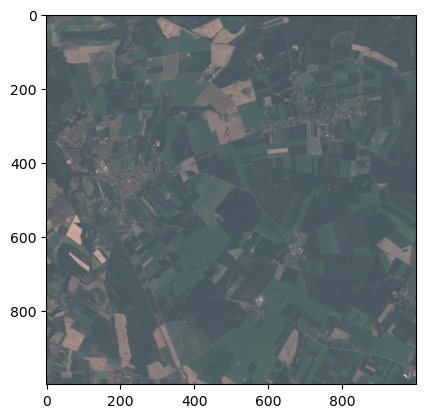

In [42]:
# Read the patch files
band2 = rasterio.open(f'{Path.home()}/patch_band_2.jp2', driver='JP2OpenJPEG') #blue
band3 = rasterio.open(f'{Path.home()}/patch_band_3.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open(f'{Path.home()}/patch_band_4.jp2', driver='JP2OpenJPEG') #red

red = band4.read(1)
green = band3.read(1)
blue = band2.read(1)

# Normalize the pixel values and apply gain
gain = 2
red_n = np.clip(red*gain/10000,0,1)
green_n = np.clip(green*gain/10000,0,1)
blue_n = np.clip(blue*gain/10000,0,1)

# Create composite image
rgb_composite_n= np.dstack((red_n, green_n, blue_n))

# Display image
plt.imshow(rgb_composite_n)

# Save image to file
matplotlib.image.imsave(f'{Path.home()}/Sentinel2_true_color.jpeg', rgb_composite_n)
print("Saved as:", outfile)

####
#### Explore the Documentation to learn more about the available APIs and services:
#### https://knowledgebase.code-de.org/en/latest/
#### https://knowledgebase.eo-lab.org/en/latest/